In [21]:
# Some minor setup for the notebook
import warnings
import nest_asyncio

# Ignore all warnings
warnings.filterwarnings("ignore")

# Allows for running async code in Jupyter notebooks
nest_asyncio.apply()

In [12]:
from dotenv import load_dotenv

load_dotenv(override=True)

True

In [7]:
from datasets import load_dataset

ms_marco = load_dataset("microsoft/ms_marco", "v2.1")

In [54]:
import numpy as np
from scipy.stats import kendalltau
from sklearn.metrics import precision_score, recall_score


def ndcg(retrieved_list, relevant_list, k=None):
    def dcg(scores):
        return sum(score / (i + 1) for i, score in enumerate(scores))

    if k is None:
        k = len(retrieved_list)

    retrieved_scores = [1 if doc in relevant_list else 0 for doc in retrieved_list[:k]]
    ideal_scores = sorted(retrieved_scores, reverse=True)

    dcg_value = dcg(retrieved_scores)
    idcg_value = dcg(ideal_scores)

    return dcg_value / idcg_value if idcg_value > 0 else 0


def mean_reciprocal_rank(retrieved_list, relevant_list):
    ranks = []
    for relevant in relevant_list:
        try:
            rank = retrieved_list.index(relevant) + 1
        except ValueError:
            rank = len(retrieved_list) + 1  # Not found
        ranks.append(rank)
    return 1.0 / min(ranks) if ranks else 0.0


def calculate_kendall_tau(retrieved_list, relevant_list):
    n_results = len(retrieved_list)
    retrieved_ranks = [retrieved_list.index(p) if p in retrieved_list else n_results for p in relevant_list]
    relevant_ranks = list(range(len(relevant_list)))

    # Calculate Kendall tau
    tau, _ = kendalltau(retrieved_ranks, relevant_ranks)

    return tau


def calculate_ndcg(retrieved_list, relevant_list, k=None):
    def dcg(scores):
        return sum(score / (np.log2(idx + 2)) for idx, score in enumerate(scores))

    if k is None:
        k = len(retrieved_list)

    # Relevance scores for retrieved documents
    retrieved_scores = [1 if doc in relevant_list else 0 for doc in retrieved_list[:k]]
    # Ideal relevance scores
    ideal_scores = sorted(retrieved_scores, reverse=True)

    dcg_value = dcg(retrieved_scores)
    idcg_value = dcg(ideal_scores)

    return dcg_value / idcg_value if idcg_value > 0 else 0


def calculate_precision(retrieved_list, relevant_list):
    y_true = [1 if doc in relevant_list else 0 for doc in retrieved_list]
    y_pred = [1] * len(y_true)  # Assuming all retrieved documents are relevant for calculating precision
    return precision_score(y_true, y_pred, zero_division=0)


def calculate_recall(retrieved_list, relevant_list):
    y_true = [1 if doc in relevant_list else 0 for doc in relevant_list]
    y_pred = [1 if doc in retrieved_list else 0 for doc in relevant_list]
    return recall_score(y_true, y_pred, zero_division=0)


def compute_all_stats(retrieved_list, relevant_list):
    return {
        'MRR': mean_reciprocal_rank(retrieved_list, relevant_list),
        'Kendall-Tau': calculate_kendall_tau(retrieved_list, relevant_list),
        'nDCG': calculate_ndcg(retrieved_list, relevant_list, k=len(relevant_list)),
        'Precision': calculate_precision(retrieved_list, relevant_list),
        'Recall': calculate_recall(retrieved_list, relevant_list),
    }

In [36]:
# Use subset for demonstration
subset = ms_marco['train'].select(range(1000))

In [8]:
print(subset[2]['query'])

why did stalin want control of eastern europe


In [9]:
from langchain_community.retrievers import BM25Retriever
from langchain_core.documents import Document

In [11]:
# Prepare the documents for BM25
bm25_docs = [Document(page_content=passage) for data in subset for passage in data['passages']['passage_text']]

# Initialize BM25 Retriever
bm25_retriever = BM25Retriever.from_documents(bm25_docs)

In [33]:
import os
from ragstack_colbert import CassandraDatabase, ColbertEmbeddingModel

keyspace = "benchmarksmarco1000parallel"
database_id = os.getenv("ASTRA_DATABASE_ID")
astra_token = os.getenv("ASTRA_TOKEN")

database = CassandraDatabase.from_astra(
    astra_token=astra_token,
    database_id=database_id,
    keyspace=keyspace
)

embedding_model = ColbertEmbeddingModel()

In [34]:
from ragstack_langchain.colbert import ColbertVectorStore as LangchainColbertVectorStore

lc_vector_store = LangchainColbertVectorStore(
    database=database,
    embedding_model=embedding_model,
)

In [15]:
all_texts = []
all_metadatas = []
i = 0
for row in subset:
    all_texts.extend(row['passages']['passage_text'])
    all_metadatas.extend([{'row_id': i} for _ in row['passages']['is_selected']])
    i += 1


In [53]:
print("Number of texts:", len(all_texts))

Number of texts: 9992


In [ ]:
lc_vector_store.add_texts(all_texts, metadatas=all_metadatas)

In [ ]:
from tqdm import tqdm

colbert_retrieved_list = []
colbert_relevant_list = []
for row in tqdm(subset):
    query = row['query']
    n_results = len(row['passages']['is_selected'])
    raw_results = lc_vector_store.similarity_search(query, k=n_results)
    retrieved_list = [result.page_content for result in raw_results]
    relevant_list = row['passages']['passage_text']

    colbert_retrieved_list.append(retrieved_list)
    colbert_relevant_list.append(relevant_list)

  3%|▎         | 31/1000 [00:25<08:30,  1.90it/s] 

In [ ]:
# calculate stats
colbert_stats = [compute_all_stats(retrieved_list, relevant_list) for retrieved_list, relevant_list in
                 zip(colbert_retrieved_list, colbert_relevant_list)]

In [55]:
# Now test BM25
bm25_retrieved_list = []
bm25_relevant_list = []

for row in tqdm(subset):
    query = row['query']
    n_results = len(row['passages']['is_selected'])
    raw_results = bm25_retriever.invoke(query, k=n_results)
    retrieved_list = [result.page_content for result in raw_results]
    relevant_list = row['passages']['passage_text']

    bm25_retrieved_list.append(retrieved_list)
    bm25_relevant_list.append(relevant_list)


100%|██████████| 1000/1000 [00:06<00:00, 155.95it/s]


In [56]:
bm25_stats = [compute_all_stats(retrieved_list, relevant_list) for retrieved_list, relevant_list in
              zip(bm25_retrieved_list, bm25_relevant_list)]

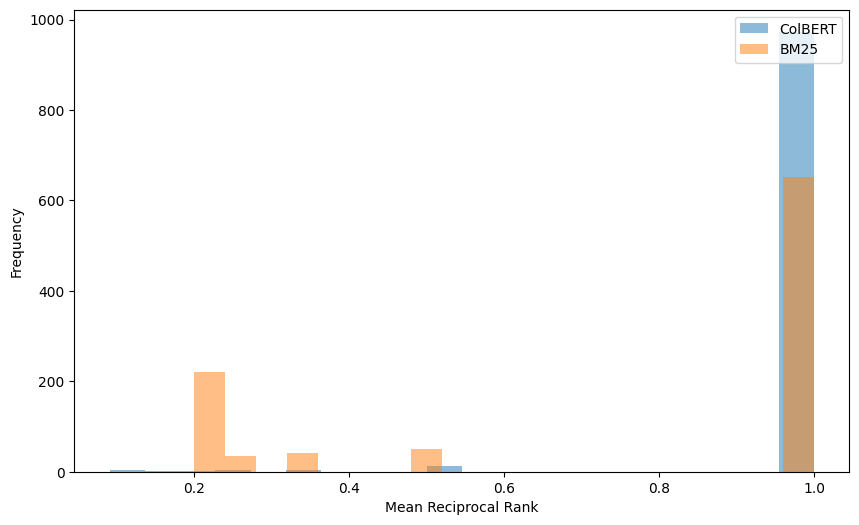

In [52]:
# Use rich to print a table for ColBERT vs. BM25
from rich import print
from rich.table import Table

table = Table(title="ColBERT vs. BM25")
table.add_column("Metric")
table.add_column("ColBERT")
table.add_column("BM25")

for metric in colbert_stats[0].keys():
    colbert_values = [stats[metric] for stats in colbert_stats]
    bm25_values = [stats[metric] for stats in bm25_stats]
    
    table.add_row(metric, f"{np.mean(colbert_values):.4f}", f"{np.mean(bm25_values):.4f}")
    
print(table)